In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv(r'data/historical_data.csv')
data.drop(columns=['Class'], inplace=True)
data

,DateTime,RR,SPO2,MAP,SBP,DBP,HR,PP,CO
0,2020-10-18 15:24,35.0,99.9,0.0,0.0,0.0,106.9,0.0,0.00
1,2020-10-18 15:25,36.4,100.0,87.0,98.9,63.1,107.3,35.8,3841.34
2,2020-10-18 15:26,35.2,100.0,75.2,97.9,63.0,107.5,34.9,3751.75
3,2020-10-18 15:27,34.0,100.0,74.8,97.2,62.5,107.0,34.7,3712.90
4,2020-10-18 15:28,34.9,100.0,74.0,96.0,62.0,107.0,34.0,3638.00
...,...,...,...,...,...,...,...,...,...
9008,2020-10-24 21:32,13.6,94.0,64.4,92.0,51.2,91.6,40.8,3737.28
9009,2020-10-24 21:33,16.7,93.6,62.8,89.3,50.2,90.7,39.1,3546.37
9010,2020-10-24 21:34,12.0,94.3,63.7,91.2,50.6,90.4,40.6,3670.24
9011,2020-10-24 21:35,13.7,94.0,64.4,91.6,51.1,91.8,40.5,3717.90


In [3]:

def clean_data(data):
    # Replace zero values in 'SBP' and 'DBP' columns with NaN
    data[['SBP', 'DBP']] = data[['SBP', 'DBP']].replace(0, np.nan)
    
    # Linear interpolation between adjacent rows
    data[['SBP', 'DBP']] = data[['SBP', 'DBP']].interpolate(method='linear', limit_direction='both')
    
    # If there are still NaN values at the edges, replace them with the mean of the adjacent rows
    data[['SBP', 'DBP']] = data[['SBP', 'DBP']].fillna(data[['SBP', 'DBP']].mean())
    
    return data

In [4]:
data = clean_data(data)
data

,DateTime,RR,SPO2,MAP,SBP,DBP,HR,PP,CO
0,2020-10-18 15:24,35.0,99.9,0.0,98.9,63.1,106.9,0.0,0.00
1,2020-10-18 15:25,36.4,100.0,87.0,98.9,63.1,107.3,35.8,3841.34
2,2020-10-18 15:26,35.2,100.0,75.2,97.9,63.0,107.5,34.9,3751.75
3,2020-10-18 15:27,34.0,100.0,74.8,97.2,62.5,107.0,34.7,3712.90
4,2020-10-18 15:28,34.9,100.0,74.0,96.0,62.0,107.0,34.0,3638.00
...,...,...,...,...,...,...,...,...,...
9008,2020-10-24 21:32,13.6,94.0,64.4,92.0,51.2,91.6,40.8,3737.28
9009,2020-10-24 21:33,16.7,93.6,62.8,89.3,50.2,90.7,39.1,3546.37
9010,2020-10-24 21:34,12.0,94.3,63.7,91.2,50.6,90.4,40.6,3670.24
9011,2020-10-24 21:35,13.7,94.0,64.4,91.6,51.1,91.8,40.5,3717.90


In [5]:
# threshold values for blood pressure levels
normal_sbp_upper = 120
normal_dbp_upper = 80
elevated_sbp_upper = 129
elevated_dbp_upper = 89
hypertension_stage_1_sbp_upper = 139
hypertension_stage_1_dbp_upper = 89

def categorize_bp(sbp, dbp, hr, spo2):
    if sbp == 0 and dbp == 0 and (hr == 0 or hr > 80) and (spo2 == 0 or spo2 > 80):
        return 'Invalid Measurement'  
    elif sbp < normal_sbp_upper and dbp < normal_dbp_upper:
        return 'Normal'
    elif sbp < elevated_sbp_upper and dbp < elevated_dbp_upper:
        return 'Elevated'
    elif sbp < hypertension_stage_1_sbp_upper and dbp < hypertension_stage_1_dbp_upper:
        return 'Hypertension Stage 1'
    else:
        return 'Hypertension Stage 2 or higher'


data['class'] = data.apply(lambda row: categorize_bp(row['SBP'], row['DBP'], row['HR'], row['SPO2']), axis=1)

In [6]:
data[data['class'] != 'Normal']['class'].value_counts()

class
Elevated                          103
Hypertension Stage 1                9
Hypertension Stage 2 or higher      4
Name: count, dtype: int64

In [7]:
# Function to assign labels based on 'class' column
def assign_label(row):
    if row['class'] == 'Normal':
        return 0
    else:
        return 1

# Applying the function to create a new 'label' column
data['label'] = data.apply(assign_label, axis=1)

In [8]:
data['label'].value_counts()

label
0    8897
1     116
Name: count, dtype: int64

In [9]:
data.head()

,DateTime,RR,SPO2,MAP,SBP,DBP,HR,PP,CO,class,label
0,2020-10-18 15:24,35.0,99.9,0.0,98.9,63.1,106.9,0.0,0.00,Normal,0
1,2020-10-18 15:25,36.4,100.0,87.0,98.9,63.1,107.3,35.8,3841.34,Normal,0
2,2020-10-18 15:26,35.2,100.0,75.2,97.9,63.0,107.5,34.9,3751.75,Normal,0
3,2020-10-18 15:27,34.0,100.0,74.8,97.2,62.5,107.0,34.7,3712.90,Normal,0
4,2020-10-18 15:28,34.9,100.0,74.0,96.0,62.0,107.0,34.0,3638.00,Normal,0


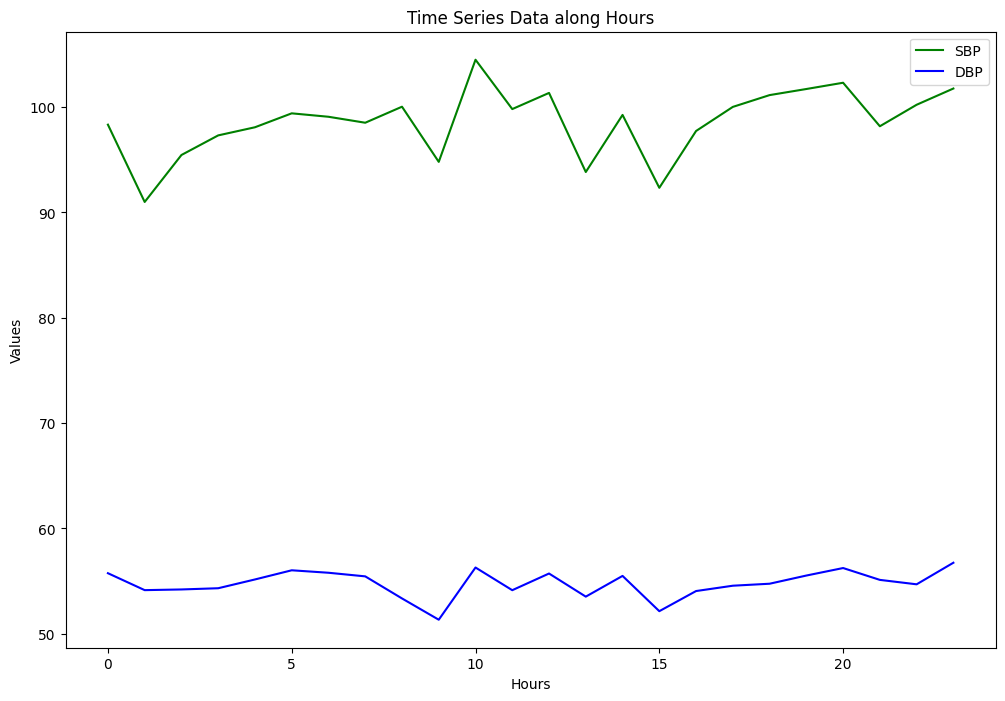

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
data['DateTime'] = pd.to_datetime(data['DateTime'])
data = data.set_index('DateTime')

# Selecting only relevant columns for resampling
data_numeric = data[['SBP', 'DBP']]  # Assuming these are the columns of interest

# Resampling to hourly mean values for numeric columns
data_hourly_mean = data_numeric.resample('H').mean().reset_index()

data_hourly_mean['hour'] = data_hourly_mean['DateTime'].dt.hour

plt.figure(figsize=(12, 8))

# Group by 'hour' and calculate mean for 'SBP' and 'DBP'
hourly_mean = data_hourly_mean.groupby('hour').mean()

plt.plot(hourly_mean.index, hourly_mean['SBP'], color='green', label='SBP')
plt.plot(hourly_mean.index, hourly_mean['DBP'], color='blue', label='DBP')

plt.xlabel('Hours')
plt.ylabel('Values')
plt.title('Time Series Data along Hours')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
data['DateTime'] = pd.to_datetime(data['DateTime'])
data['weekday'] = pd.Categorical(data['DateTime'].dt.strftime('%A'),
                                 categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                 ordered=True)

# Group by 'weekday' and calculate mean for 'SBP' and 'DBP'
data_numeric = data[['SBP', 'DBP', 'weekday']]  
daily_mean = data_numeric.groupby('weekday').mean()

plt.figure(figsize=(10, 6))

# Creating bar plots for SBP and DBP
plt.plot(daily_mean.index, daily_mean['SBP'], color='green', alpha=0.7, label='SBP')
plt.plot(daily_mean.index, daily_mean['DBP'], color='blue', alpha=0.7, label='DBP')

plt.xlabel('Days of the Week')
plt.ylabel('Mean Values')
plt.title('Mean SBP and DBP across Days of the Week')
plt.legend()
plt.tight_layout()
plt.show()


## ANOMALY DETECTION

In [10]:
from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame containing columns 'SBP' and 'DBP'

# Split the data into train and test sets
X = data
# Assuming you have a target variable named 'target_column'
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
X_test

,DateTime,RR,SPO2,MAP,SBP,DBP,HR,PP,CO,class,label
6111,2020-10-22 21:15,14.1,98.9,68.8,98.3,55.7,83.7,42.6,3565.62,Normal,0
2484,2020-10-20 8:48,24.2,99.9,65.8,92.7,51.3,75.1,41.4,3109.14,Normal,0
2508,2020-10-20 9:12,26.6,99.5,68.5,95.4,53.7,76.4,41.7,3185.88,Normal,0
6098,2020-10-22 21:02,16.0,99.0,69.9,100.5,56.3,82.7,44.2,3655.34,Normal,0
1188,2020-10-19 11:12,14.4,100.0,74.6,104.2,59.6,85.9,44.6,3831.14,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...
7394,2020-10-23 18:38,23.5,99.5,81.1,112.5,64.1,80.6,48.4,3901.04,Normal,0
1437,2020-10-19 15:21,23.1,97.2,68.5,96.8,55.4,84.0,41.4,3477.60,Normal,0
2199,2020-10-20 4:03,19.4,98.0,86.2,133.8,79.8,73.0,54.0,3942.00,Hypertension Stage 1,1
8673,2020-10-24 15:57,25.3,95.0,63.7,91.7,50.0,95.4,41.7,3978.18,Normal,0


In [12]:
from sklearn.model_selection import GridSearchCV
import warnings
# Suppress sklearn warning about scoring failures
warnings.filterwarnings("ignore", message="Scoring failed.*")

# Assuming 'data' is your DataFrame containing columns 'SBP' and 'DBP'

# Define hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_samples': ['auto', 100, 200],
    'contamination': [ 0.03, 0.05, 0.1]
}

# Initialize Isolation Forest
model = IsolationForest(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearch to find the best hyperparameters
grid_search.fit(X_train[['SBP', 'DBP']])

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Hyperparameters: {'contamination': 0.03, 'max_samples': 'auto', 'n_estimators': 100}


In [13]:
# Use the best hyperparameters to create the final model
best_model = IsolationForest(**best_params, random_state=42)

# Fit the final model to your data
best_model.fit(X_train[['SBP', 'DBP']])

IsolationForest(contamination=0.03, random_state=42)

In [ ]:
# # Parameters for Isolation Forest
# contamination_value = 0.03
# n_estimators_value = 200  
# max_samples_value = 'auto'  
# max_features_value = 1.0  # (1.0 means considering all features)
# random_state_value = 42  # to ensure reproducibility

# # Initialize Isolation Forest with specified parameters
# model = IsolationForest(
#     n_estimators=n_estimators_value,
#     max_samples=max_samples_value,
#     contamination=contamination_value,
#     max_features=max_features_value,
#     random_state=random_state_value
# )

# Calculate anomaly scores and predictions within a rolling window
window_size = 5
data['score'] = float('nan')  # Initializing the score column


for i in range(len(data)):
    if i >= window_size - 1:
        window_data = data.iloc[i - window_size + 1:i + 1][['SBP', 'DBP']]
        best_model.fit(window_data)
        scores = best_model.decision_function(window_data)
        print(i)
        for j, score in enumerate(scores):
            data.at[data.index[i - window_size + 1 + j], 'score'] = score  # Assign the score to each row in the window

print(data.tail())  # Display the updated DataFrame

In [14]:
best_model.fit(X_train[['SBP', 'DBP']])
X_test['score'] = best_model.decision_function(X_test[['SBP', 'DBP']])
X_test['anomaly_value'] = best_model.predict(X_test[['SBP', 'DBP']])
X_test.head()

,DateTime,RR,SPO2,MAP,SBP,DBP,HR,PP,CO,class,label,score,anomaly_value
6111,2020-10-22 21:15,14.1,98.9,68.8,98.3,55.7,83.7,42.6,3565.62,Normal,0,0.160536,1
2484,2020-10-20 8:48,24.2,99.9,65.8,92.7,51.3,75.1,41.4,3109.14,Normal,0,0.146548,1
2508,2020-10-20 9:12,26.6,99.5,68.5,95.4,53.7,76.4,41.7,3185.88,Normal,0,0.159163,1
6098,2020-10-22 21:02,16.0,99.0,69.9,100.5,56.3,82.7,44.2,3655.34,Normal,0,0.177426,1
1188,2020-10-19 11:12,14.4,100.0,74.6,104.2,59.6,85.9,44.6,3831.14,Normal,0,0.162463,1


anomaly_value
 1    1733
-1      70
Name: count, dtype: int64


<Axes: xlabel='anomaly_value'>

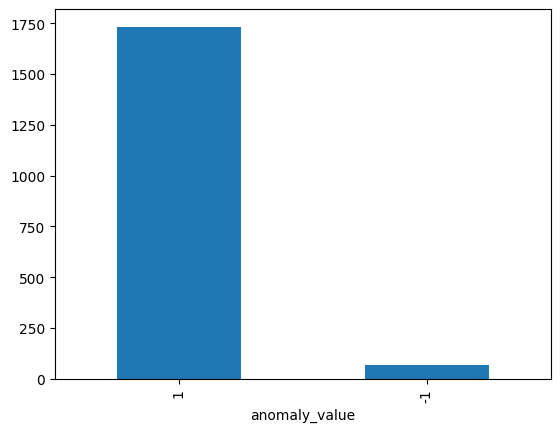

In [15]:
outliers = X_test.loc[X_test['anomaly_value'] == -1]
outlier_index = list(outliers.index)

#datapoints classified -1 are anomalous
print(X_test['anomaly_value'].value_counts())
X_test['anomaly_value'].value_counts().plot(kind = 'bar')

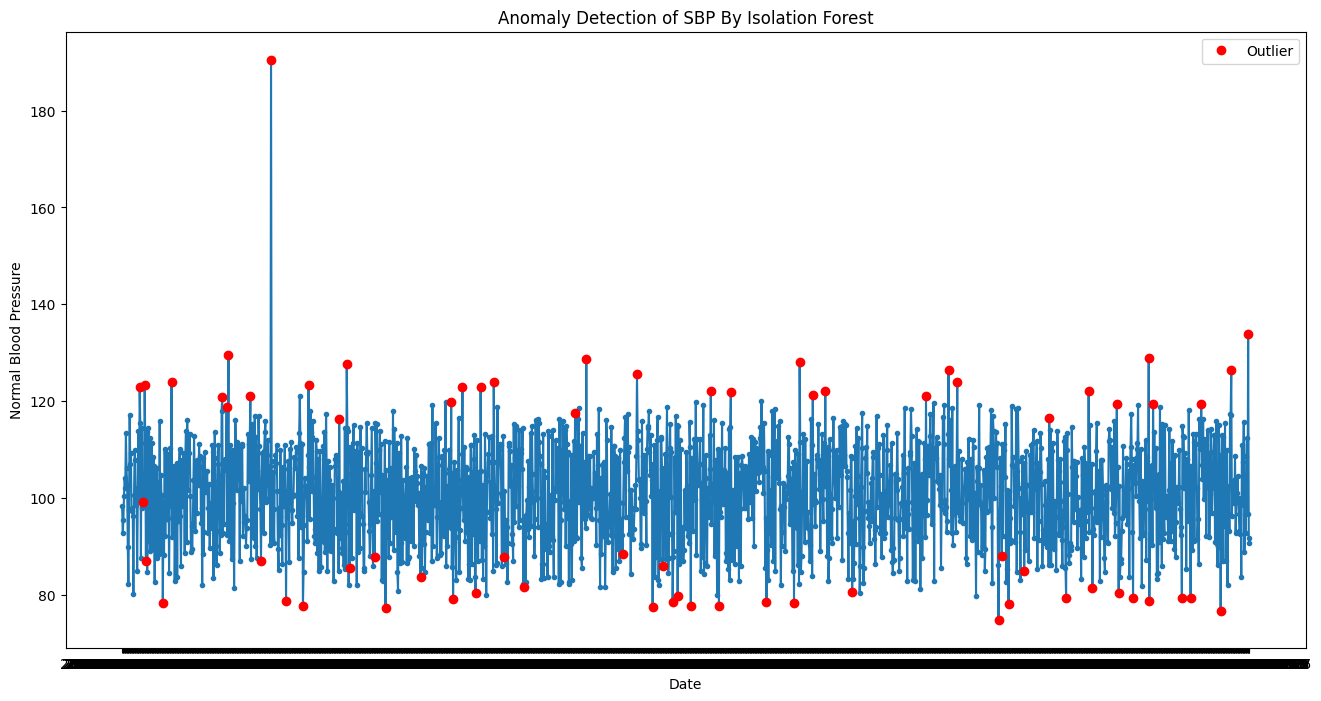

In [25]:
plt.figure(figsize = (16, 8))

plt.plot(X_test['DateTime'], X_test[['SBP']], marker = '.')
# Ensure the length of outliers matches the length of the dates
outlier_dates = outliers['DateTime']
outlier_values = outliers[['SBP']]

# Plot outliers only if they exist
if len(outlier_dates) == len(outlier_values):
    plt.plot(outlier_dates, outlier_values, 'o', color='red', label='Outlier')

plt.title('Anomaly Detection of SBP By Isolation Forest')

#plt.grid()
plt.xlabel('Date')
plt.ylabel('Normal Blood Pressure')
plt.legend()

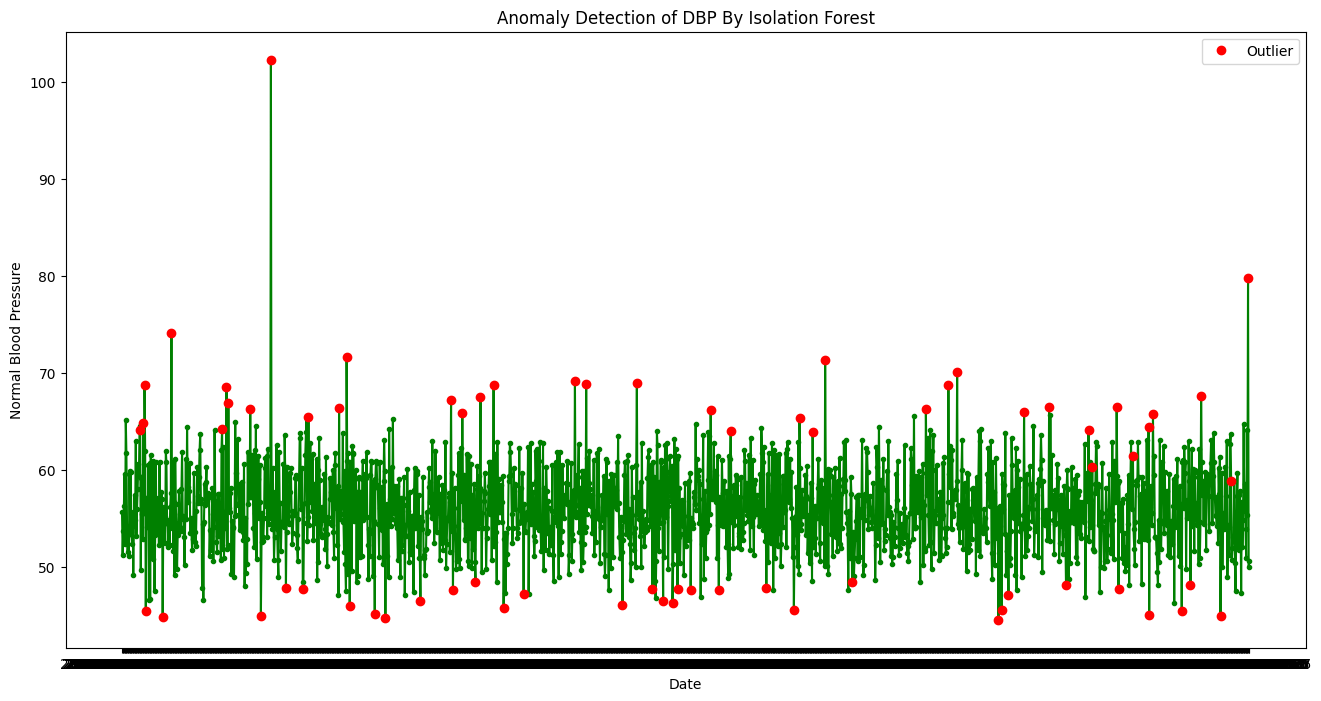

In [26]:
plt.figure(figsize = (16, 8))

plt.plot(X_test['DateTime'], X_test[['DBP']], marker = '.', color = 'green')
# Ensure the length of outliers matches the length of the dates
outlier_dates = outliers['DateTime']
outlier_values = outliers[['DBP']]

# Plot outliers only if they exist
if len(outlier_dates) == len(outlier_values):
    plt.plot(outlier_dates, outlier_values, 'o', color='red', label='Outlier')

plt.title('Anomaly Detection of DBP By Isolation Forest')

#plt.grid()
plt.xlabel('Date')
plt.ylabel('Normal Blood Pressure')
plt.legend()

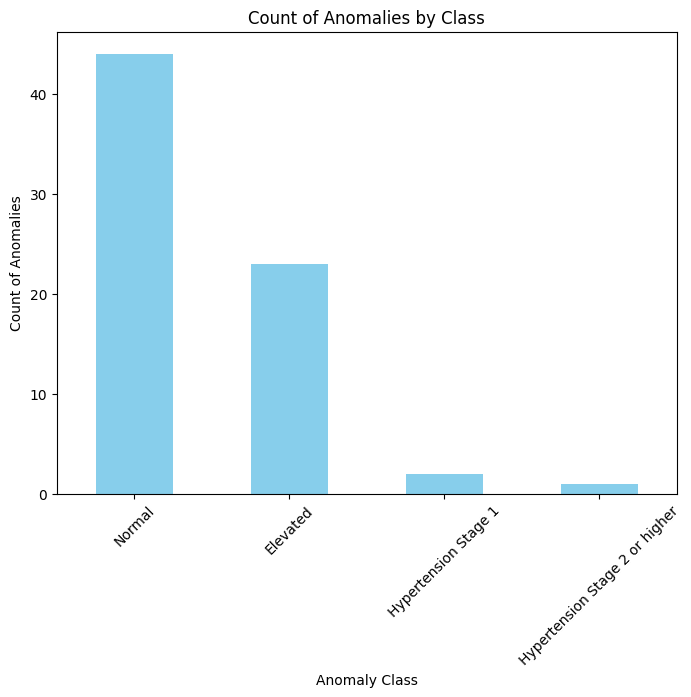

In [17]:
import matplotlib.pyplot as plt

# Assuming 'class' column contains the classes of anomalies
# 'anomaly_value' column indicates whether it's an anomaly or not (1 for anomaly, 0 for normal)

# Filter anomalies from the data
anomalies = X_test[X_test['anomaly_value'] == -1]

# Plot histogram of anomaly classes
plt.figure(figsize=(8, 6))
anomalies['class'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Anomaly Class')
plt.ylabel('Count of Anomalies')
plt.title('Count of Anomalies by Class')
plt.xticks(rotation=45)  
plt.show()


In [21]:
X_test[X_test['anomaly_value'] == -1]['DBP']

5376    64.100000
518     64.900000
6593    68.833333
5103    45.500000
6838    44.900000
          ...    
7076    48.200000
4562    67.700000
6841    45.000000
1111    58.900000
2199    79.800000
Name: DBP, Length: 70, dtype: float64

In [19]:
X_test[X_test['anomaly_value'] == -1]['class'].value_counts()

class
Normal                            44
Elevated                          23
Hypertension Stage 1               2
Hypertension Stage 2 or higher     1
Name: count, dtype: int64

In [22]:
import joblib

# Assuming 'model' is your trained Isolation Forest model

# Save the model to a file
joblib.dump(best_model, 'isolation_forest_model.joblib')

['isolation_forest_model.joblib']

In [24]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score

# Assuming 'data' is your DataFrame with columns 'label' and 'anomaly'
true_labels = X_test['label']
predicted_labels = X_test['anomaly_value'].map({-1: 1, 1: 0}) 

# Calculate performance metrics
conf_matrix = confusion_matrix(true_labels, predicted_labels)
classification_rep = classification_report(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, X_test['score'])  
average_precision = average_precision_score(true_labels, X_test['score'])  # Replace 'anomaly_score' as above

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_rep)

print(f"\nROC AUC: {roc_auc:.4f}")
print(f"AUC-PR: {average_precision:.4f}")

Confusion Matrix:
[[1731   44]
 [   2   26]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1775
           1       0.37      0.93      0.53        28

    accuracy                           0.97      1803
   macro avg       0.69      0.95      0.76      1803
weighted avg       0.99      0.97      0.98      1803


ROC AUC: 0.0081
AUC-PR: 0.0081
